In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


import os
print(os.listdir("../data"))
import warnings
warnings.filterwarnings('ignore')

['IMDB Dataset.csv']


In [57]:
import joblib


models_path = "../models/"

X_train_uni = joblib.load(models_path + "X_train_uni.pkl")
X_test_uni = joblib.load(models_path + "X_test_uni.pkl")
X_train, X_test, y_train, y_test = joblib.load(models_path + "split_data.pkl")
tfidf_uni = joblib.load(models_path + "tfidf_uni.pkl")

In [58]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

lr = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_uni, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidate parameter i

In [59]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)

{'C': 10}
0.896125


The best C parameter is 10 & The best CV score is 0.89

In [60]:
best_lr = grid_lr.best_estimator_

y_pred_best = best_lr.predict(X_test_uni)
y_prob_best = best_lr.predict_proba(X_test_uni)[:,1]


In [61]:
y_prob_best

array([0.56988385, 0.27487739, 0.92779398, ..., 0.00121719, 0.94529287,
       0.27530858], shape=(10000,))

In [62]:
# classification_report
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Accuracy: 0.9026
              precision    recall  f1-score   support

    negative       0.90      0.90      0.90      5000
    positive       0.90      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



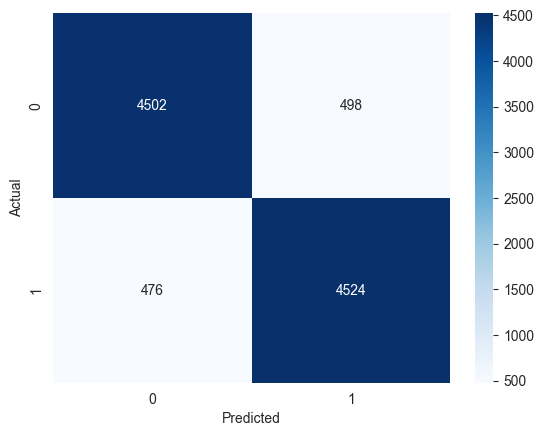

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [64]:
# roc - auc

roc_auc = roc_auc_score(y_test, y_prob_best)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.96490348


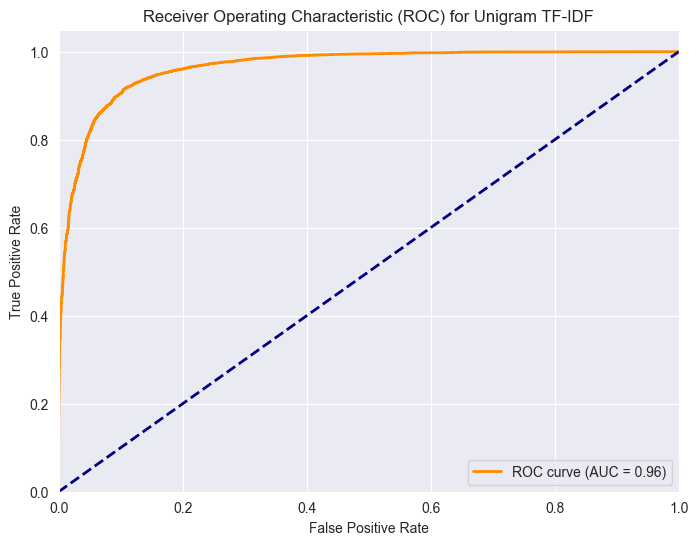

In [65]:
y_true_mapped = np.where(y_test == 'positive', 1, 0) # convert y_test to binary
fpr, tpr, _ = roc_curve(y_true_mapped, y_prob_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Unigram TF-IDF')
plt.legend(loc="lower right")
plt.legend()

In [66]:
from sklearn.svm import LinearSVC

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10]
}

svm = LinearSVC(
    max_iter=5000,
    random_state=42
)

grid_svm = GridSearchCV(
    svm,
    param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train_uni, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LinearSVC(max...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidate parameter i

In [67]:
best_svm = grid_svm.best_estimator_

y_pred_svm = best_svm.predict(X_test_uni)

In [68]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'C': 0.01}
nan


In [69]:
# classification_report
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.872
              precision    recall  f1-score   support

    negative       0.89      0.85      0.87      5000
    positive       0.86      0.90      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



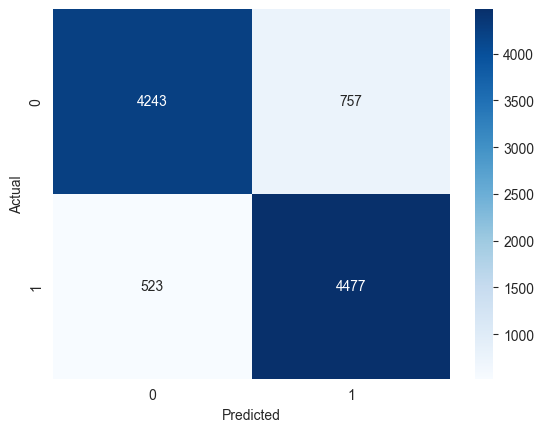

In [70]:
cm = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [71]:
compare_dict = {
    "Logistic Regression Baseline": {
        "C": 1,
        "Accuracy": 0.9004,
        "F1": 0.90,
        "ROC-AUC": 0.96344208},
    "Logistic Regression Tuned": {
        "C": 10,
        "Accuracy": 0.9026,
        "F1": 0.90,
        "ROC-AUC": 0.96490348},
    "SVM": {
        "C": 0.01,
        "Accuracy": 0.872,
        "F1": 0.87,
        "ROC-AUC": None }
}


In [72]:
df_compare = (pd.DataFrame(compare_dict).T.reset_index()
              .rename(columns={'index': 'Model'}))

fig = go.Figure()

metrics = ['Accuracy', 'F1', 'ROC-AUC']
for metric in metrics:
    fig.add_trace(go.Bar(
        x=df_compare['Model'],
        y=df_compare[metric],
        name=metric,
        text=df_compare[metric].apply(lambda x: f'{x:.3f}' if x is not None else ''),
        textposition='auto'
    ))

fig.update_layout(
    title='Comparing performance between models',
    xaxis_title='Model',
    yaxis_title='Value',
    barmode='group',
    yaxis=dict(range=[0.8, 1.0])
)
fig.show()

- LogisticRegression after tuned get a little better score than the previous LogisticRegression
- SVM has lower score than both LogisticRegression

## Day 5A – Model Tuning Summary

- Tuning regularization strength improves baseline performance
- Logistic Regression achieves optimal performance at C = 10
- Linear SVM performs worse than other LogisticRegression
- Feature representation remains the dominant factor in performance
